In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Load data

In [12]:
data = pd.read_csv('UoB_Set01_2025-01-02_dt.csv')

#data.set_index('Datetime', inplace=True)
print(data.head())

              Datetime  Bid1_Price  Bid1_Volume  Ask1_Price  Ask1_Volume  \
0  2025-01-02 07:30:00  261.840893    60.428571  270.011964    38.517857   
1  2025-01-02 07:31:00  258.679231    46.230769  263.964808    31.326923   
2  2025-01-02 07:32:00  263.103167    43.333333  267.750167    35.300000   
3  2025-01-02 07:33:00  263.017333    33.433333  267.201667    35.266667   
4  2025-01-02 07:34:00  263.175000    56.050000  268.676333    41.083333   

   Bid2_Price  Bid2_Volume  Ask2_Price  Ask2_Volume   Mid-Price  ...  \
0  254.583214    48.589286  274.216964    39.839286  265.927321  ...   
1  254.827885    47.692308  283.130192    33.807692  261.322308  ...   
2  260.417000    53.650000  271.332667    28.683333  265.426667  ...   
3  260.786500    48.616667  269.988333    32.983333  265.109333  ...   
4  260.355167    64.650000  273.013333    41.200000  265.925167  ...   

   Market_Depth_Ask  Historical_Volatility  Weighted_Avg_Bid_Price  \
0         78.357143               5.4246

Run Simulation

In [28]:
# Initial conditions
initial_cash = 10000  # Starting cash
cash = initial_cash
shares_owned = 0  # Starting shares owned
transactions = []  # List to record transactions

# Parameters for market impact, slippage, and fees
market_impact_constant = 0.1
average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
brokerage_fee_bps = 0.50 / 100
exchange_fee_per_share = 0.000025
shares_per_transaction = 500

# Thresholds
bid_ask_spread_threshold = data['Bid_Ask_Spread'].quantile(0.5)  # Liquidity - median spread as threshold 
order_imbalance_threshold = 0.10  # Volume - laceholder value

# if moving average then define the window size for the moving average
sma_window_size = 10
# Calculate the SMA for Mid-Price
data['SMA_Mid_Price'] = data['Mid-Price'].rolling(window=sma_window_size).mean()

# Holding Threshilds
volatility_threshold = 0.05  # Placeholder for volatility threshold
proximity_threshold = 0.02  # Placeholder for how close the price should be to the SMA to consider holding

# Run simulation
for i in range(sma_window_size, len(data)):
    current_mid_price = data.iloc[i]['Mid-Price']
    average_mid_price = data.iloc[i]['SMA_Mid_Price']
    order_imbalance = data.iloc[i]['Order_imbalance']
    bid_ask_spread = data.iloc[i]['Bid_Ask_Spread']  # Use the actual column for bid-ask spread
    is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
    price_proximity = abs(current_mid_price - average_mid_price) / average_mid_price
    volatility = data.iloc[i]['Historical_Volatility']
    is_hold_condition = (price_proximity < proximity_threshold or volatility > volatility_threshold)

    # Buy condition
    if current_mid_price < average_mid_price and is_liquid:
        shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
        if shares_to_buy > 0:
            volume_ratio = shares_to_buy / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
    
    # Sell condition
    elif current_mid_price > average_mid_price and is_liquid and shares_owned > 0:
        volume_ratio = shares_owned / average_daily_volume
        price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
        adjusted_sell_price = current_mid_price - price_impact
        total_revenue = adjusted_sell_price * shares_owned - brokerage_fee_bps * adjusted_sell_price * shares_owned - exchange_fee_per_share * shares_owned
        cash += total_revenue
        transactions.append(('Sell', shares_owned, adjusted_sell_price, total_revenue, cash, i))
        shares_owned = 0

    # Hold condition
    elif is_hold_condition:
        # Log hold action only if conditions suggest increased risk or uncertainty
        transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

final_valuation_corrected = cash + shares_owned * data.iloc[-1]['Mid-Price']

output = {
    "Initial Cash": initial_cash,
    "Final Valuation": final_valuation_corrected,
    "Overall Profit/Loss": final_valuation_corrected - initial_cash,
    "Number of Transactions": len(transactions),
    "First 5 Transactions": transactions[:5]
}

print(f'Overall Profit/Loss": {final_valuation_corrected - initial_cash}')


Overall Profit/Loss": -5641.233114423141


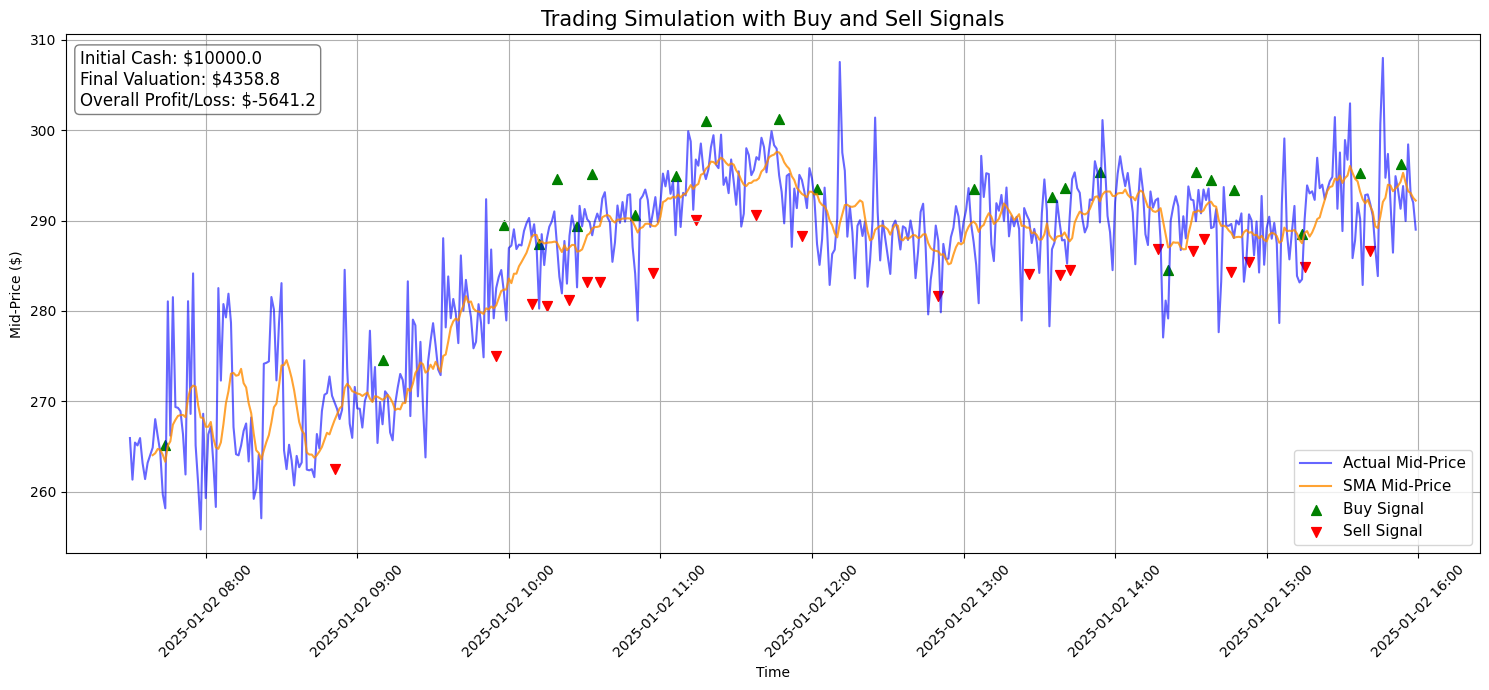

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert transactions to a df
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])
# 'Time' in transactions was an index in transactions so map it to a Datetime
transactions_df['Datetime'] = transactions_df['Time'].apply(lambda x: data.iloc[x]['Datetime'])

# plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['Datetime'], data['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)
ax.plot(data['Datetime'], data['SMA_Mid_Price'], label='SMA Mid-Price', color='darkorange', alpha=0.8)

# add buy and sell signals
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals['Datetime'], buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=50, alpha=1.0)
ax.scatter(sell_signals['Datetime'], sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=50, alpha=1.0)

# format the x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Add labels with model results
final_valuation = final_valuation_corrected  # From the previous output
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes (adjust the x and y values based on your plot's layout)
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Time')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


Export the figure

In [20]:
fig.savefig('Trading Simulation ARIMA1 Results Rolling.png', dpi=600, bbox_inches='tight')

In [1]:
def run_trading_simulation(sma_window_size, bid_ask_threshold, order_imbalance_threshold, volatility_threshold, proximity_threshold):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.50 / 100
    exchange_fee_per_share = 0.000025
    shares_per_transaction = 500
  
    data['SMA_Mid_Price'] = data['Mid-Price'].rolling(window=sma_window_size).mean()

    # Trading simulation loop (buy, sell, hold logic)
    # Run simulation
    for i in range(sma_window_size, len(data)):
        current_mid_price = data.iloc[i]['Mid-Price']
        average_mid_price = data.iloc[i]['SMA_Mid_Price']
        order_imbalance = data.iloc[i]['Order_imbalance']
        bid_ask_spread = data.iloc[i]['Bid_Ask_Spread']  # Use the actual column for bid-ask spread
        is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
        price_proximity = abs(current_mid_price - average_mid_price) / average_mid_price
        volatility = data.iloc[i]['Historical_Volatility']
        is_hold_condition = (price_proximity < proximity_threshold or volatility > volatility_threshold)

        # Buy condition
        if current_mid_price < average_mid_price and is_liquid:
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            if shares_to_buy > 0:
                volume_ratio = shares_to_buy / average_daily_volume
                price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
                adjusted_buy_price = current_mid_price + price_impact
                total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
                cash -= total_cost
                shares_owned += shares_to_buy
                transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
        
        # Sell condition
        elif current_mid_price > average_mid_price and is_liquid and shares_owned > 0:
            volume_ratio = shares_owned / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_owned - brokerage_fee_bps * adjusted_sell_price * shares_owned - exchange_fee_per_share * shares_owned
            cash += total_revenue
            transactions.append(('Sell', shares_owned, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0

        # Hold condition
        elif is_hold_condition:
            # Log hold action only if conditions suggest increased risk or uncertainty
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']
    return final_valuation - initial_cash

# Parameter ranges (example ranges, adjust as needed)
sma_window_sizes = [10, 15, 20]
bid_ask_thresholds = [0.01, 0.02]
order_imbalance_thresholds = [0.05, 0.1]
volatility_thresholds = [0.03, 0.06]
proximity_thresholds = [0.01, 0.02]

results = []

# Iterating over all combinations of parameters
for sma_size in sma_window_sizes:
    for bid_ask_thresh in bid_ask_thresholds:
        for order_imbalance_thresh in order_imbalance_thresholds:
            for volatility_thresh in volatility_thresholds:
                for proximity_thresh in proximity_thresholds:
                    profit_loss = run_trading_simulation(sma_size, bid_ask_thresh, order_imbalance_thresh, volatility_thresh, proximity_thresh)
                    results.append((sma_size, bid_ask_thresh, order_imbalance_thresh, volatility_thresh, proximity_thresh, profit_loss))

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=['SMA Size', 'Bid-Ask Thresh', 'Order Imbalance Thresh', 'Volatility Thresh', 'Proximity Thresh', 'Profit/Loss'])

print(results_df)

NameError: name 'data' is not defined